In [1]:
%matplotlib inline


# 3 - Non-linear models: unscented Kalman filter


The previous tutorial showed how the extended Kalman filter propagates estimates using a
first-order linearisation of the transition and/or sensor models. Clearly there are limits to
such an approximation, and in situations where models deviate significantly from linearity,
performance can suffer.

In such situations it can be beneficial to seek alternative approximations. One such comes via
the so-called *unscented transform* (UT). In this we characterise a Gaussian distribution using a
series of weighted samples, *sigma points*, and propagate these through the non-linear function.
A transformed Gaussian is then reconstructed from the new sigma points. This forms the basis for
the unscented Kalman filter (UKF).

This tutorial will first run a simulation in an entirely equivalent fashion to the previous
(EKF) tutorial. We'll then look into more precise details concerning the UT and try and develop
some intuition into the reasons for its effectiveness.



## Background
Limited detail on how Stone Soup does the UKF is provided below. See Julier et al. (2000) [#]_
for fuller, better details of the UKF.

For dimension $D$, a set of $2 D + 1$ sigma points are calculated at:

\begin{align}\mathbf{s}_j &= \mathbf{x}, \ \ j = 0 \\
          \mathbf{s}_j &= \mathbf{x} + \alpha \sqrt{\kappa} A_j, \ \ j = 1, ..., D \\
          \mathbf{s}_j &= \mathbf{x} - \alpha \sqrt{\kappa} A_j, \ \ j = D + 1, ..., 2 D\end{align}

where $A_j$ is the $j$ th column of $A$, a *square root matrix* of the
covariance, $P = AA^T$, of the state to be approximated, and $\mathbf{x}$ is its
mean.

Two sets of weights, mean and covariance, are calculated:

\begin{align}W^m_0 &= \frac{\lambda}{c} \\
          W^c_0 &= \frac{\lambda}{c} + (1 - \alpha^2 + \beta) \\
          W^m_j &= W^c_j = \frac{1}{2 c}\end{align}

where $c = \alpha^2 (D + \kappa)$, $\lambda = c - D$. The parameters
$\alpha, \ \beta, \ \kappa$ are user-selectable parameters with default values of
$0.5, \ 2, \ 3 - D$.

After the sigma points are transformed $\mathbf{s^{\prime}} = f( \mathbf{s} )$, the
distribution is reconstructed as:

\begin{align}\mathbf{x}^\prime &= \sum\limits^{2 D}_{0} W^{m}_j \mathbf{s}^{\prime}_j \\
          P^\prime &= (\mathbf{s}^{\prime} - \mathbf{x}^\prime) \, diag(W^c) \,
          (\mathbf{s}^{\prime} - \mathbf{x}^\prime)^T + Q\end{align}

The posterior mean and covariance are accurate to the 2nd order Taylor expansion for any
non-linear model. [#]_



## Nearly-constant velocity example
This example is equivalent to that in the previous (EKF) tutorial. As with that one, you are
invited to play with the parameters and watch what happens.



In [2]:
# Some general imports and initialise time
import numpy as np

from datetime import datetime, timedelta
start_time = datetime.now()

In [3]:
np.random.seed(1991)

### Create ground truth




In [4]:
from stonesoup.types.groundtruth import GroundTruthPath, GroundTruthState
from stonesoup.models.transition.linear import CombinedLinearGaussianTransitionModel, \
                                               ConstantVelocity

transition_model = CombinedLinearGaussianTransitionModel([ConstantVelocity(0.05),
                                                          ConstantVelocity(0.05)])
truth = GroundTruthPath([GroundTruthState([0, 1, 0, 1], timestamp=start_time)])

for k in range(1, 21):
    truth.append(GroundTruthState(
        transition_model.function(truth[k-1], noise=True, time_interval=timedelta(seconds=1)),
        timestamp=start_time+timedelta(seconds=k)))

Set-up plot to render ground truth, as before.



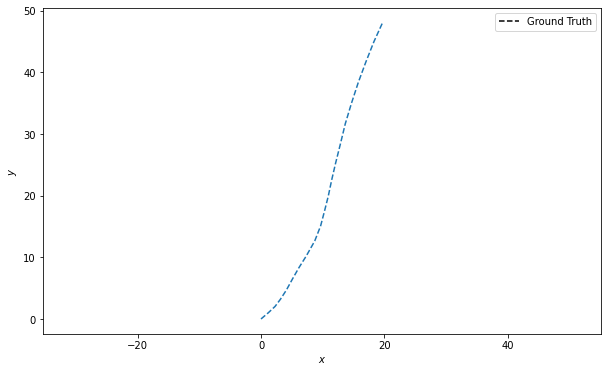

In [5]:
from stonesoup.plotter import Plotter
plotter = Plotter()
plotter.plot_ground_truths(truth, [0, 2])

### Simulate the measurement




In [6]:
from stonesoup.models.measurement.nonlinear import CartesianToBearingRange
# Sensor position
sensor_x = 50
sensor_y = 0

# Make noisy measurement (with bearing variance = 0.2 degrees).
measurement_model = CartesianToBearingRange(ndim_state=4,
                                            mapping=(0, 2),
                                            noise_covar=np.diag([np.radians(0.2), 1]),
                                            translation_offset=np.array([[sensor_x], [sensor_y]]))

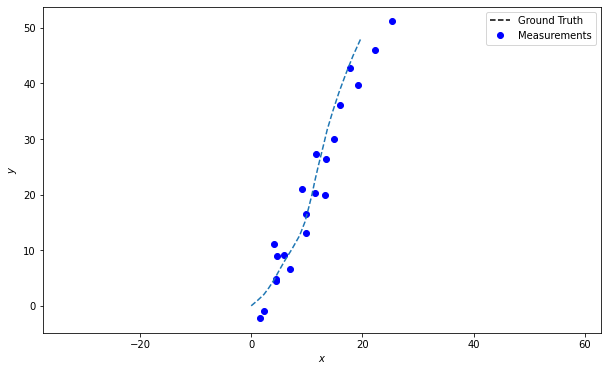

In [7]:
from stonesoup.types.detection import Detection

# Make sensor that produces the noisy measurements.
measurements = []
for state in truth:
    measurement = measurement_model.function(state, noise=True)
    measurements.append(Detection(measurement, timestamp=state.timestamp,
                                  measurement_model=measurement_model))

# Plot the measurements
# Where the model is nonlinear the plotting function uses the inverse function to get coordinates

plotter.plot_measurements(measurements, [0, 2])
plotter.fig

### Create unscented Kalman filter components
Note that the transition of the target state is linear, so we have no real need for a
:class:`~.UnscentedKalmanPredictor`. But we'll use one anyway, if nothing else to demonstrate
that a linear model won't break anything.



In [8]:
from stonesoup.predictor.kalman import UnscentedKalmanPredictor
predictor = UnscentedKalmanPredictor(transition_model)
# Create :class:`~.UnscentedKalmanUpdater`
from stonesoup.updater.kalman import UnscentedKalmanUpdater
unscented_updater = UnscentedKalmanUpdater(measurement_model)  # Keep alpha as default = 0.5

### Run the Unscented Kalman Filter

Create a prior



In [9]:
from stonesoup.types.state import GaussianState
prior = GaussianState([[0], [1], [0], [1]], np.diag([1.5, 0.5, 1.5, 0.5]), timestamp=start_time)

Populate the track



In [10]:
from stonesoup.types.hypothesis import SingleHypothesis
from stonesoup.types.track import Track

track = Track()
for measurement in measurements:
    prediction = predictor.predict(prior, timestamp=measurement.timestamp)
    hypothesis = SingleHypothesis(prediction, measurement)
    post = unscented_updater.update(hypothesis)
    track.append(post)
    prior = track[-1]

And plot



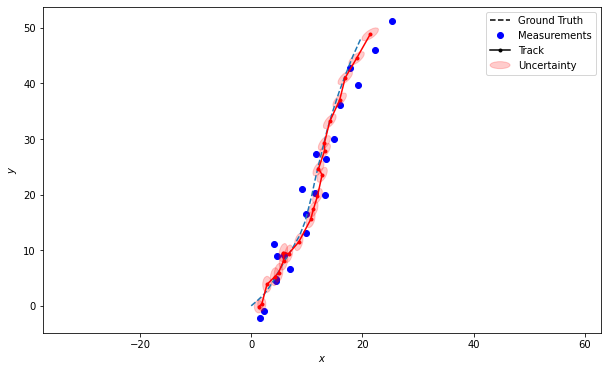

In [11]:
plotter.plot_tracks(track, [0, 2], uncertainty=True, color='r')
plotter.fig

## The UT in slightly more depth
Now try and get a sense of what actually happens to the uncertainty when a non-linear combination
of functions happens. Instead of deriving this analytically (and potentially getting bogged-down
in the maths), let's just use a sampling method.
We can start with a prediction, which is Gauss-distributed in state space, that we will use to
make our measurement predictions from.



In [12]:
from stonesoup.types.prediction import GaussianStatePrediction
prediction = GaussianStatePrediction(state_vector=[[0], [0], [20], [0]],
                                     covar=np.diag([1.5, 0.5, 1.5, 0.5]),
                                     timestamp=datetime.now())

We'll recapitulate the fact that the sensor position is where it previously was. But this time
we'll make the measurement much noisier.



In [13]:
sensor_x = 0
sensor_y = 0

measurement_model = CartesianToBearingRange(
    ndim_state=4,
    mapping=(0, 2),
    noise_covar=np.diag([np.radians(5), 0.1]),  # bearing variance = 5 degrees (accurate range)
    translation_offset=np.array([[sensor_x], [sensor_y]])
)

The next tutorial will go into much more detail on sampling methods. For the moment we'll just
assert that we're generating 2000 points from the state prediction above.

We need these imports and parameters:



In [14]:
from scipy.stats import multivariate_normal

from stonesoup.types.particle import Particle
from stonesoup.types.numeric import Probability  # Similar to a float type
from stonesoup.types.state import ParticleState

number_particles = 2000

# Sample from the Gaussian prediction distribution
samples = multivariate_normal.rvs(prediction.state_vector.ravel(),
                                  prediction.covar,
                                  size=number_particles)
particles = [
    Particle(sample.reshape(-1, 1), weight=Probability(1/number_particles)) for sample in samples]
# Create prior particle state.
pred_samples = ParticleState(particles, timestamp=start_time)

from stonesoup.resampler.particle import SystematicResampler
resampler = SystematicResampler()
from stonesoup.updater.particle import ParticleUpdater
pupdater = ParticleUpdater(measurement_model, resampler)

predict_meas_samples = pupdater.predict_measurement(pred_samples)

Don't worry what all this means for the moment. It's a convenient way of showing the 'true'
distribution of the predicted measurement - which is rendered as a blue cloud. Note that
no noise is added by the :meth:`~.UnscentedKalmanUpdater.predict_measurement` method so we add
some noise below. This is additive Gaussian in the sensor coordinates.



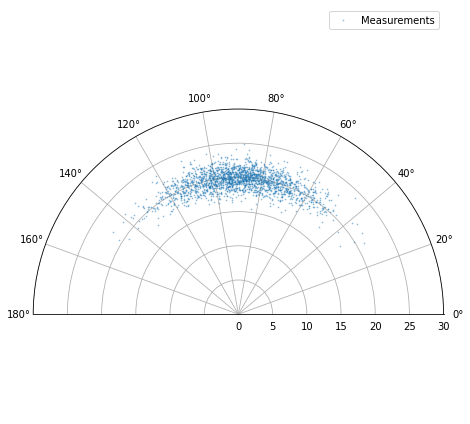

In [15]:
from matplotlib import pyplot as plt
fig = plt.figure(figsize=(10, 6), tight_layout=True)
ax = fig.add_subplot(1, 1, 1, polar=True)
ax.set_ylim(0, 30)
ax.set_xlim(0, np.radians(180))

data = np.array([particle.state_vector for particle in predict_meas_samples.particles])
noise = multivariate_normal.rvs(np.array([0, 0]), measurement_model.covar(), size=len(data))

ax.plot(data[:, 0].ravel()+noise[:, 0],
        data[:, 1].ravel()+noise[:, 1],
        linestyle='',
        marker=".",
        markersize=1.5,
        alpha=0.4,
        label="Measurements")
ax.legend()

We can now see what happens when we create EKF and UKF updaters and compare their effect.

Create updaters:



In [16]:
from stonesoup.updater.kalman import UnscentedKalmanUpdater, ExtendedKalmanUpdater
unscented_updater = UnscentedKalmanUpdater(measurement_model, alpha=0.5, beta=4)
extended_updater = ExtendedKalmanUpdater(measurement_model)

# Get predicted measurements from the state prediction.
ukf_pred_meas = unscented_updater.predict_measurement(prediction)
ekf_pred_meas = extended_updater.predict_measurement(prediction)

Plot UKF (red) and EKF (green) predicted measurement distributions.



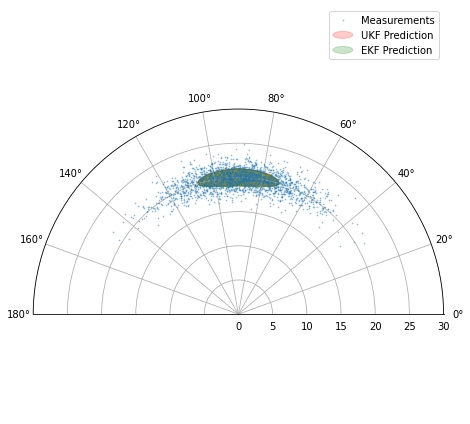

In [17]:
# Plot UKF's predicted measurement distribution
from matplotlib.patches import Ellipse
w, v = np.linalg.eig(ukf_pred_meas.covar)
max_ind = np.argmax(w)
min_ind = np.argmin(w)
orient = np.arctan2(v[1, max_ind], v[0, max_ind])
ukf_ellipse = Ellipse(xy=(ukf_pred_meas.state_vector[0], ukf_pred_meas.state_vector[1]),
                      width=2*np.sqrt(w[max_ind]), height=2*np.sqrt(w[min_ind]),
                      angle=np.rad2deg(orient),
                      alpha=0.4,
                      color='r',)
ax.add_artist(ukf_ellipse)


# Plot EKF's predicted measurement distribution
w, v = np.linalg.eig(ekf_pred_meas.covar)
max_ind = np.argmax(w)
min_ind = np.argmin(w)
orient = np.arctan2(v[1, max_ind], v[0, max_ind])
ekf_ellipse = Ellipse(xy=(ekf_pred_meas.state_vector[0], ekf_pred_meas.state_vector[1]),
                      width=2*np.sqrt(w[max_ind]), height=2*np.sqrt(w[min_ind]),
                      angle=np.rad2deg(orient),
                      alpha=0.5,
                      color='g',)
ax.add_artist(ekf_ellipse)

# Add ellipses to legend
label_list = ["UKF Prediction", "EKF Prediction"]
color_list = ['r', 'g']
plotter.ellipse_legend(ax, label_list, color_list)
fig

You may have to spend some time fiddling with the parameters to see major differences between the
EKF and UKF. Indeed the point to make is not that there is any great magic about the UKF. Its
power is that it harnesses some extra free parameters to give a more flexible description of the
transformed distribution.



## Key points
1. The unscented Kalman filter offers a powerful alternative to the EKF when undertaking tracking
   in non-linear regimes.



## References
.. [#] Julier S., Uhlmann J., Durrant-Whyte H.F. 2000, A new method for the nonlinear
       transformation of means and covariances in filters and estimators," in IEEE Transactions
       on Automatic Control, vol. 45, no. 3, pp. 477-482, doi: 10.1109/9.847726.
.. [#] Julier S.J. 2002, The scaled unscented transformation, Proceedings of the 2002 American
       Control Conference (IEEE Cat. No.CH37301), Anchorage, AK, USA, 2002, pp. 4555-4559 vol.6,
       doi: 10.1109/ACC.2002.1025369.

